# EDA Engine

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import seaborn.objects as so

In [2]:
df = pd.read_csv("cleaned_sample.csv",parse_dates=["order_date"])

In [3]:
df=df.drop(columns=["Unnamed: 0"])

In [4]:
df.dtypes

order_id                 int64
order_date      datetime64[us]
customer_age           float64
is_premium                 str
total_amount           float64
dtype: object

In [5]:
df["order_date"].dtype

dtype('<M8[us]')

In [6]:
numerical_columns=[]
categorical_columns=[]
time_column=[]
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        numerical_columns.append(col)
    elif (df[col]).dtype=='M8[us]':
        time_column.append(col)
    else:
        categorical_columns.append(col)

In [7]:
numerical_columns,categorical_columns,time_column

(['order_id', 'customer_age', 'total_amount'], ['is_premium'], ['order_date'])

In [8]:
def remove_outliers(df):
    for col in df.columns.tolist():
        q1=df[col].quantile(0.25)
        q3=df[col].quantile(0.75)
        iqr=q3-q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] > lower_bound) | (df[col] < upper_bound)]
    return df

In [9]:
def dataset_shape(df,i):
    shape={}
    if i==0:
        return "rows:"+df.shape[0]
    elif i==1:
        return "columns:"+df.shape[1]
    else:
        shape["Rows"]=df.shape[0]
        shape["columns"]=df.shape[1]
        return shape

In [10]:
def column_types_raw(df):
    types={}
    for col in df.columns:
        types[col]=df[col].dtype
    return types

In [11]:
def missing_value_summary(df):
    null={}
    for col in df.columns:
        value=((df[col].isnull().sum())/df.shape[0])*100
        null[col]=value
    return null

In [12]:
def univariate_numerical_summary(df,numerical_columns):
    df_na=df[numerical_columns]
    return df_na.describe()


In [13]:
numerical_columns

['order_id', 'customer_age', 'total_amount']

In [14]:
univariate_numerical_summary(df,numerical_columns)

,order_id,customer_age,total_amount
count,7.000000,7.000000,7.000000
mean,1004.000000,32.090000,1260.764643
std,2.160247,7.062816,455.948667
min,1001.000000,25.000000,760.000000
25%,1002.500000,27.815000,971.926250
50%,1004.000000,29.000000,1200.500000
75%,1005.500000,35.000000,1385.500000
max,1007.000000,45.000000,2150.000000


In [15]:
def univariate_numeric(df,numerical_columns):
    list1={}
    if len(df) < 1:
        return {
            "distribution_type": "insufficient_data",
            "description": "Too few data points to determine distribution reliably."
        }
    for col in numerical_columns:
        skewness=df[col].skew()
        kurt=df[col].kurt()
        q1,q3 = df[col].quantile([0.25, 0.75])
        iqr = q3-q1
        value_range = df[col].max()-df[col].min()
        concentrated = iqr < 0.25 * value_range

        kde = gaussian_kde(df[col])
        xs = np.linspace(df[col].min(), df[col].max(), 200)
        density = kde(xs)
        peaks = ((density[1:-1] > density[:-2]) & (density[1:-1] > density[2:])).sum()

        if abs(skewness) < 0.5:
            skew_desc = "approximately symmetric"
        elif skewness > 0:
            skew_desc = "right-skewed"
        else:
            skew_desc = "left-skewed"


        if kurt > 1:
            tail_desc = "heavy-tailed"
        elif kurt < -1:
            tail_desc = "light-tailed"
        else:
            tail_desc = "moderate tails"

        
        if peaks >= 2:
            modality = "bimodal or multimodal"
        else:
            modality = "unimodal"
            

        list1[col]=skew_desc,tail_desc,modality,
    return list1


In [16]:
univariate_numeric(df,numerical_columns)

{'order_id': ('approximately symmetric', 'light-tailed', 'unimodal'),
 'customer_age': ('right-skewed', 'moderate tails', 'unimodal'),
 'total_amount': ('right-skewed', 'heavy-tailed', 'unimodal')}

In [17]:
def univariate_time(df,time_column):
    list1={}
    for col in time_column:
        count=df[col].value_counts()
        dates=count.index
        value_count=count.values
        list1[col]=dates,value_count
    return list1

In [18]:
univariate_time(df,time_column)

{'order_date': (DatetimeIndex(['2024-01-15', '2024-01-18', '2024-02-15', '2024-03-02',
                 '2024-10-03', '2024-03-15'],
                dtype='datetime64[us]', name='order_date', freq=None),
  array([2, 1, 1, 1, 1, 1]))}

In [19]:
def univariate_category(df,categorical_columns):
    list1={}
    for col in categorical_columns:
        count=df[col].value_counts()
        dates=count.index
        value_count=count.values
        dominant=df[col].value_counts().idxmax()
        list1[col]=dates,value_count,dominant
    return list1
    


In [20]:
univariate_category(df,categorical_columns)

{'is_premium': (Index(['Yes', 'No'], dtype='str', name='is_premium'),
  array([4, 3]),
  'Yes')}

In [21]:
def bivariate_numeric_vs_category(df,numerical_columns,categorical_columns):
    results={}
    for cat in categorical_columns:
        for num in numerical_columns:
            summary = df.groupby(cat)[num].agg(['sum', 'mean', 'median', 'std', 'count'])
            results[f"{num}_vs_{cat}"] = summary
    return results

In [22]:
bivariate_numeric_vs_category(df,numerical_columns,categorical_columns)

{'order_id_vs_is_premium':              sum    mean  median       std  count
 is_premium                                       
 No          3012  1004.0  1004.0  2.000000      3
 Yes         4016  1004.0  1004.0  2.581989      4,
 'customer_age_vs_is_premium':                sum       mean  median       std  count
 is_premium                                            
 No          115.00  38.333333  38.000  6.506407      3
 Yes         109.63  27.407500  27.815  1.825073      4,
 'total_amount_vs_is_premium':                   sum         mean     median         std  count
 is_premium                                                      
 No          2703.8525   901.284167   963.8525  122.621765      3
 Yes         6121.5000  1530.375000  1385.5000  423.802357      4}

In [23]:
def bivariate_numeric_vs_numeric(df,numerical_columns):
    list_corr={}
    list_cov={}
    for num in numerical_columns:
        for num2 in numerical_columns:
            if num!=num2:
                value_corr=df[num].corr(df[num2])
                value_cov=df[num].cov(df[num2])
                list_corr[f"{num}_vs_{num2}"]=value_corr
                list_cov[f"{num}_vs_{num2}"]=value_cov
    return list_corr,list_cov

In [24]:
bivariate_numeric_vs_numeric(df,numerical_columns)

({'order_id_vs_customer_age': np.float64(0.1925838183118896),
  'order_id_vs_total_amount': np.float64(0.18718240608716777),
  'customer_age_vs_order_id': np.float64(0.1925838183118896),
  'customer_age_vs_total_amount': np.float64(-0.6093497800071299),
  'total_amount_vs_order_id': np.float64(0.18718240608716777),
  'total_amount_vs_customer_age': np.float64(-0.6093497800071298)},
 {'order_id_vs_customer_age': np.float64(2.9383333333333335),
  'order_id_vs_total_amount': np.float64(184.36749999999998),
  'customer_age_vs_order_id': np.float64(2.9383333333333335),
  'customer_age_vs_total_amount': np.float64(-1962.2777875000002),
  'total_amount_vs_order_id': np.float64(184.36749999999998),
  'total_amount_vs_customer_age': np.float64(-1962.2777875000002)})

In [25]:
def bivariate_category_vs_category(df,categorical_columns):
    list1={}
    for col in categorical_columns:
        list2=[pd.crosstab(df[col], df[col])]
        list1[f"{col}_vs_{col}"]=list2
    return list1

In [26]:
bivariate_category_vs_category(df,categorical_columns)

{'is_premium_vs_is_premium': [is_premium  No  Yes
  is_premium         
  No           3    0
  Yes          0    4]}

In [27]:
def bivariate_time_vs_numeric(df,time_column,numerical_columns):
    list1={}
    for time in time_column:
        for num in numerical_columns:
            summary=df.groupby(time)[num].agg('sum')
            list1[f"{time}_vs_{num}"]=summary
    return list1


In [28]:
bivariate_time_vs_numeric(df,time_column,numerical_columns)

{'order_date_vs_order_id': order_date
 2024-01-15    2005
 2024-01-18    1002
 2024-02-15    1003
 2024-03-02    1005
 2024-03-15    1007
 2024-10-03    1006
 Name: order_id, dtype: int64,
 'order_date_vs_customer_age': order_date
 2024-01-15    70.00
 2024-01-18    32.00
 2024-02-15    29.00
 2024-03-02    28.63
 2024-03-15    27.00
 2024-10-03    38.00
 Name: customer_age, dtype: float64,
 'order_date_vs_total_amount': order_date
 2024-01-15    1960.5000
 2024-01-18     980.0000
 2024-02-15    1430.7500
 2024-03-02    2150.0000
 2024-03-15    1340.2500
 2024-10-03     963.8525
 Name: total_amount, dtype: float64}

In [29]:
def multivariate(df):
    list1=[df.corr(numeric_only=True)]
    return list1

In [30]:
multivariate(df)

[              order_id  customer_age  total_amount
 order_id      1.000000      0.192584      0.187182
 customer_age  0.192584      1.000000     -0.609350
 total_amount  0.187182     -0.609350      1.000000]

## Plots for user

In [31]:
def plot_univariate_numeric(df,numerical_columns):
    for col in numerical_columns:
        plt.figure()
        sns.histplot(df[col])
        plt.title(col)
        plt.show()

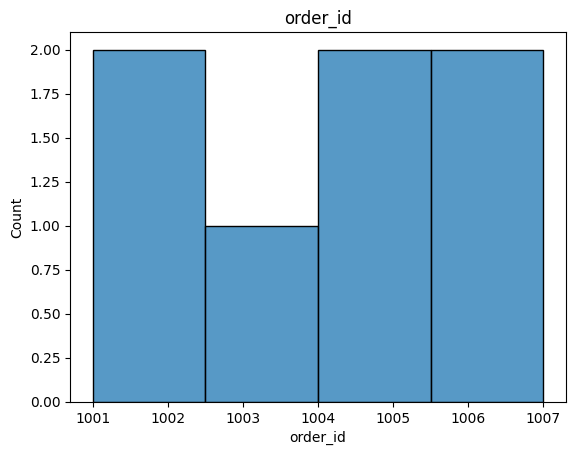

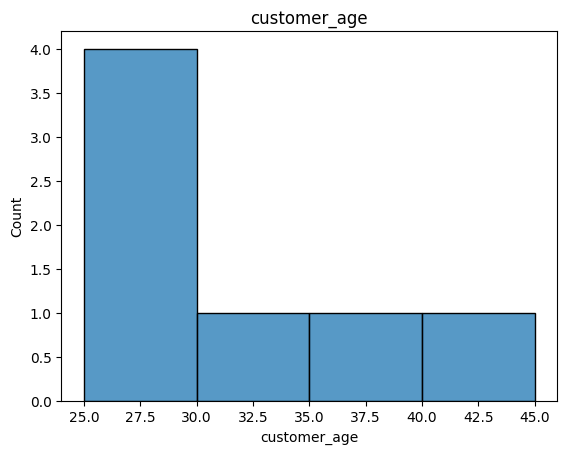

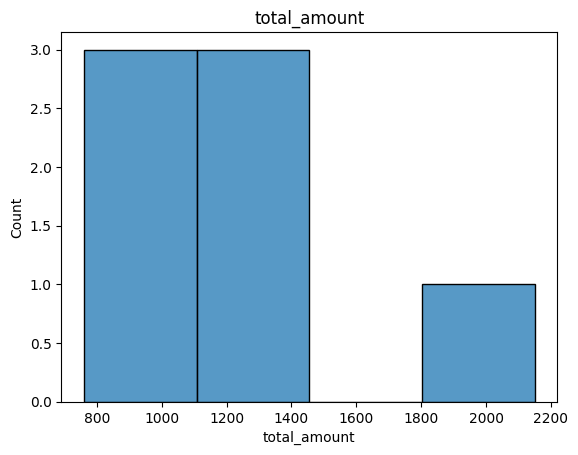

In [32]:
plot_univariate_numeric(df,numerical_columns)

In [33]:
def plot_univariate_category(df,categorical_columns):
    sns.set_theme(style="darkgrid")
    for col in categorical_columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, palette='coolwarm', hue=col, legend=False)
        plt.title(f'Distribution of {col}', fontsize=15)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

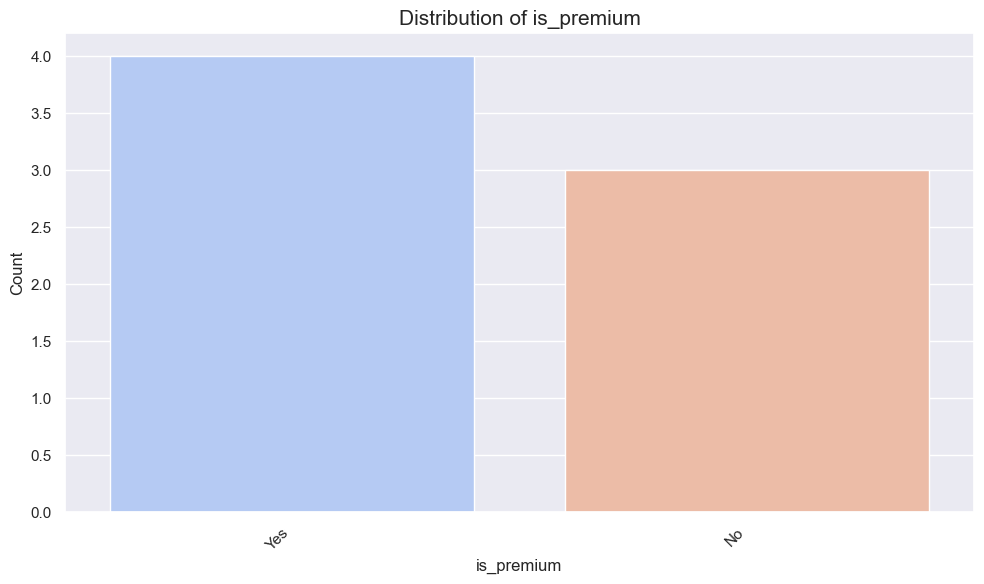

In [34]:
plot_univariate_category(df,categorical_columns)

In [35]:
def univariate_time(df,time_column):
    for col in time_column:
        plt.Figure(figsize=(10,6))
        sns.countplot(data=df,x=col,palette='coolwarm', hue=col)
        plt.title(col)
        plt.xlabel(col)
        plt.xticks(rotation=45,ha='right')
        plt.tight_layout()
        plt.show()

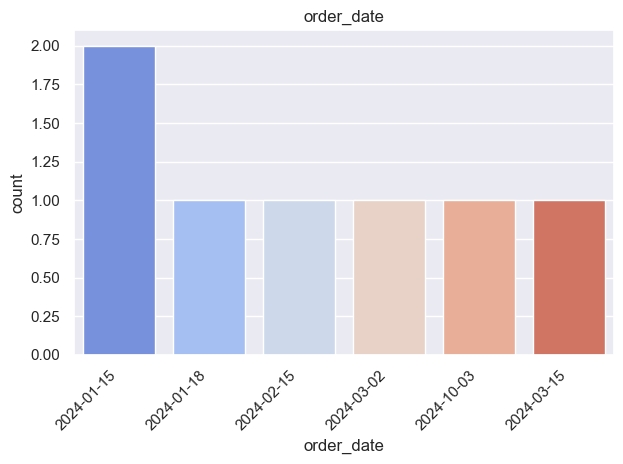

In [36]:
univariate_time(df,time_column)

In [ ]:
def plot_bivariate_numeric_vs_category(df,numerical_columns,categorical_columns):
    for cat in categorical_columns:
        for num in numerical_columns:
            plt.figure(figsize=(10,6))
            sns.boxplot(data=df, x=cat, y=num, showmeans=True, 
            palette='coolwarm', hue=cat,meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
            plt.xlabel(cat)
            plt.ylabel(num)
            plt.xticks(rotation=45,ha='right')
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(10,6))
            sns.violinplot(data=df,x=cat,y=num,palette='coolwarm', hue=cat)
            plt.xlabel(cat)
            plt.ylabel(num)
            plt.xticks(rotation=45,ha='right')
            plt.tight_layout()
            plt.show()
            
            plt.figure(figsize=(10,6))
            sns.barplot(data=df,x=cat,y=num,palette='coolwarm', hue=cat)
            plt.xlabel(cat)
            plt.ylabel(num)
            plt.xticks(rotation=45,ha='right')
            plt.tight_layout()
            plt.show()

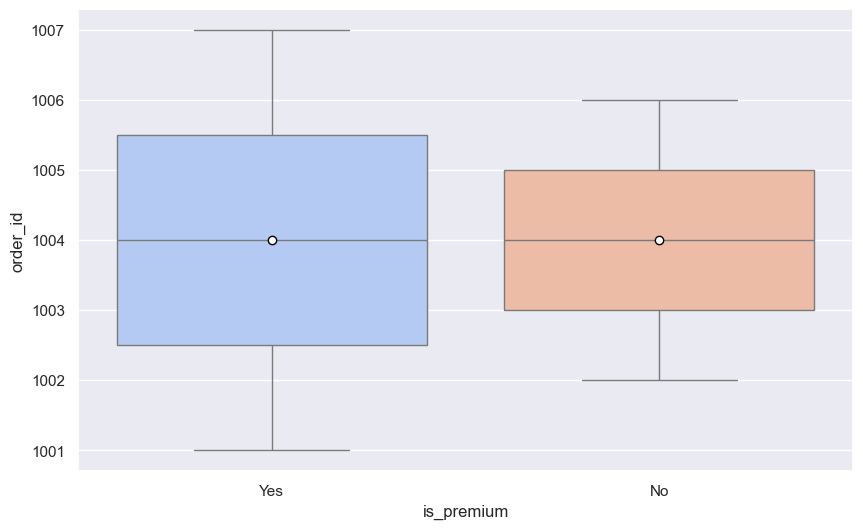

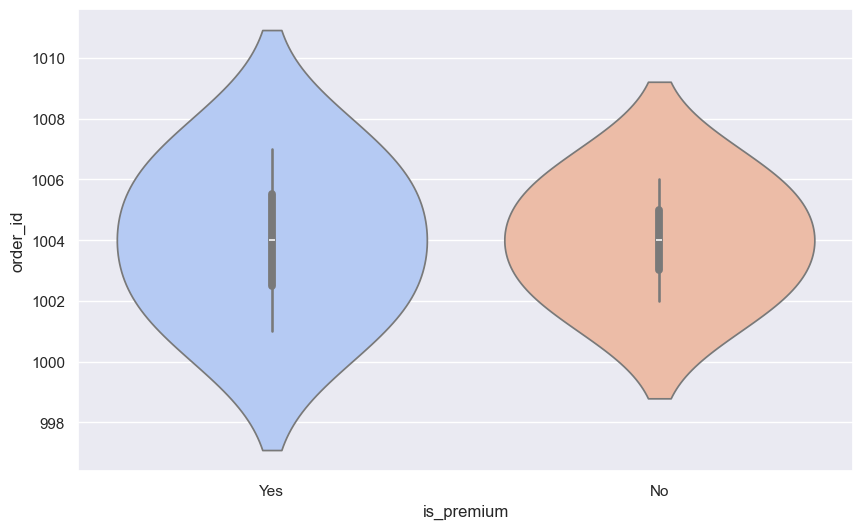

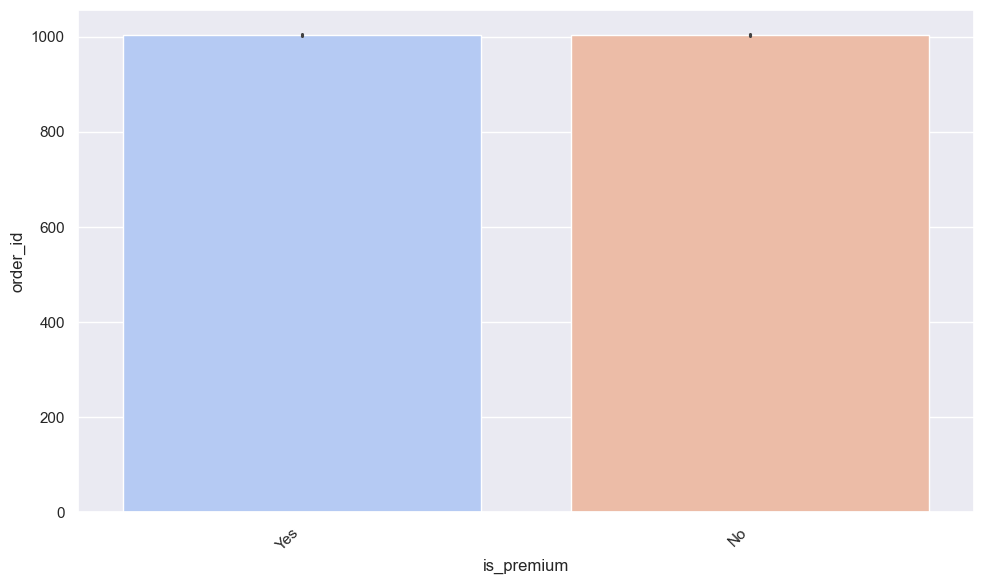

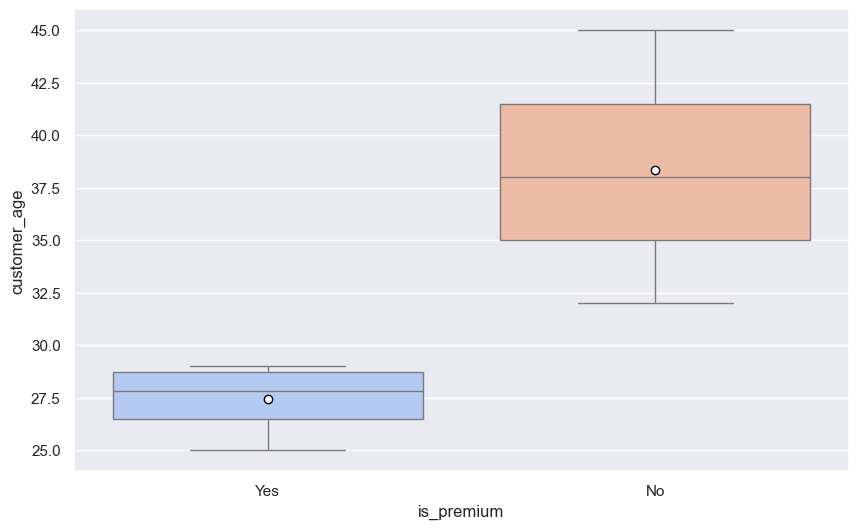

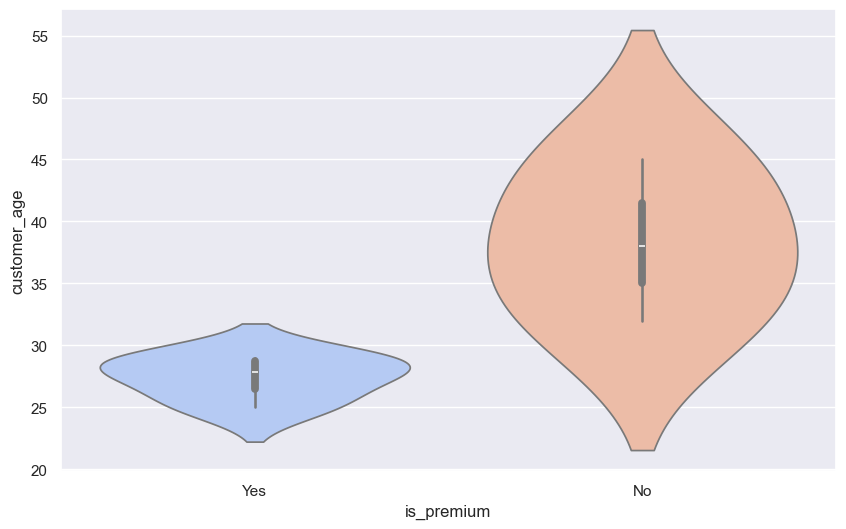

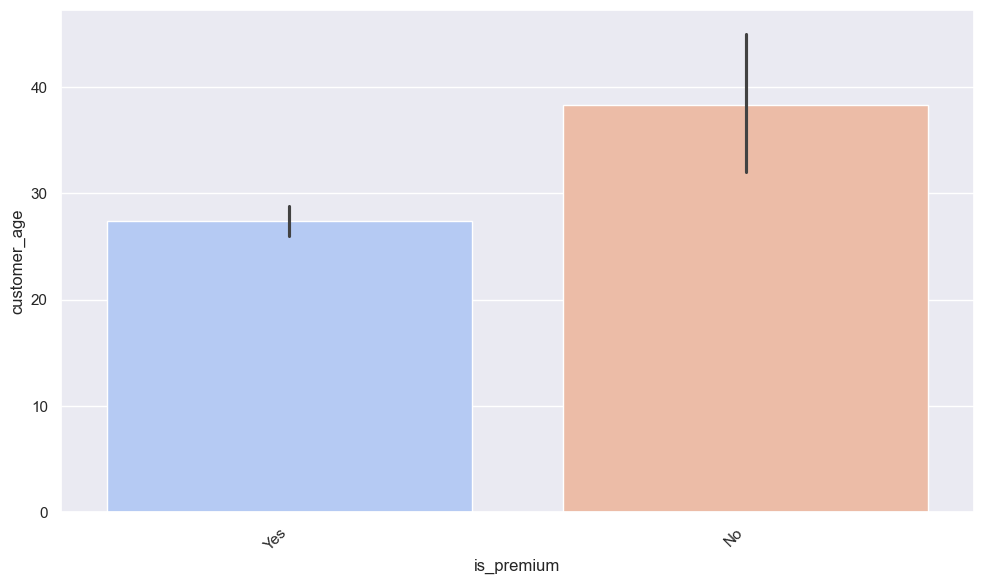

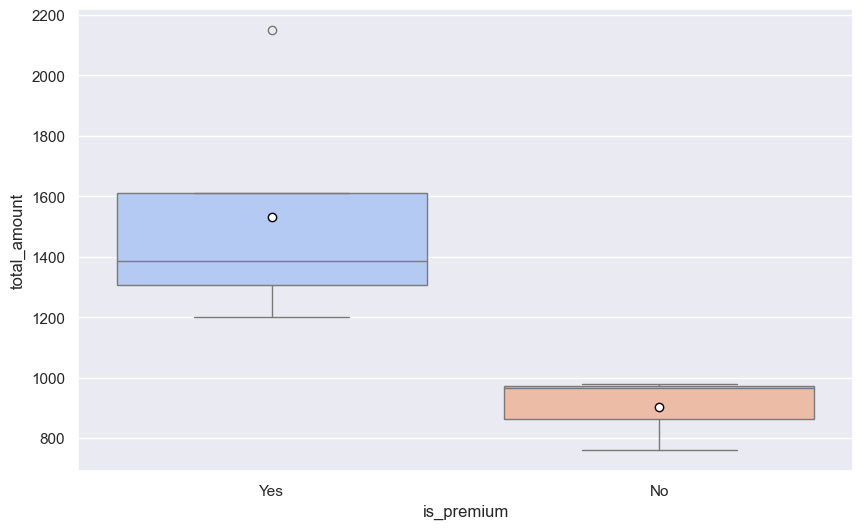

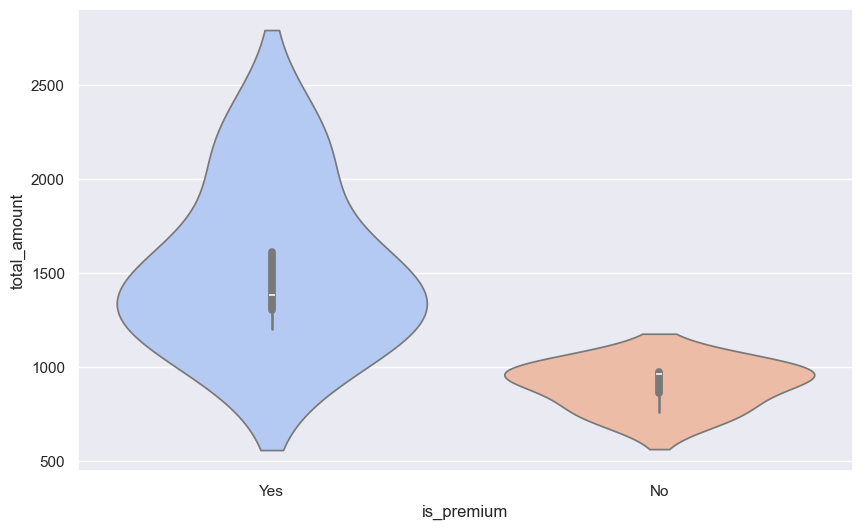

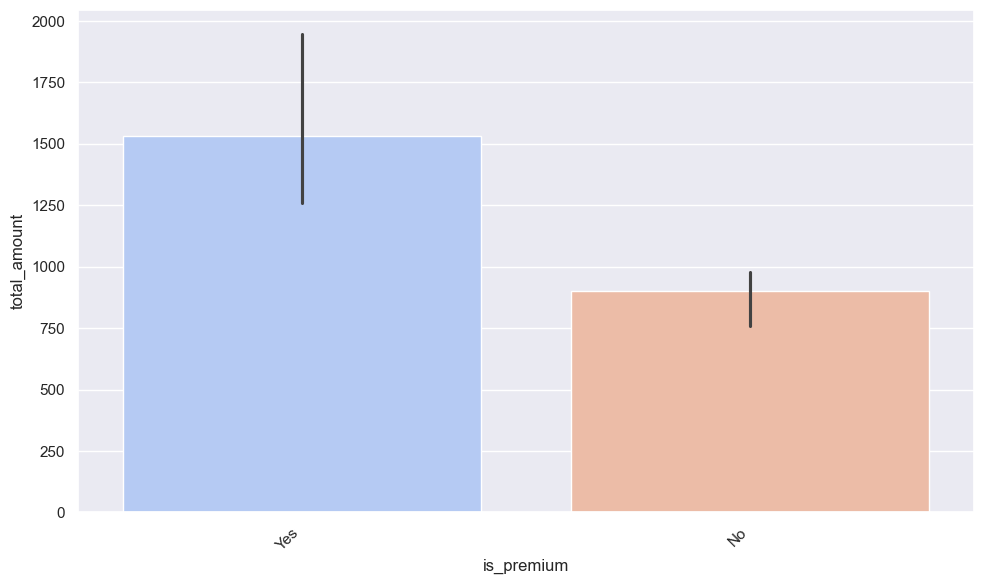

In [56]:
plot_bivariate_numeric_vs_category(df,numerical_columns,categorical_columns)

In [ ]:
def plot_bivariate_category_vs_category(df,categorical_columns):
    for col in categorical_columns:
        for col2 in reversed(categorical_columns):
            plt.figure(figsize=(10,6))
            sns.jointplot(data=df, x=col, y=col2)
            plt.xlabel(col)
            plt.ylabel(col2)
            plt.xticks(rotation=45,ha='right')
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(10,6))
            so.Plot(df,x=col, y=col2).add(so.Bar(), so.Agg())
            plt.xlabel(col)
            plt.ylabel(col2)
            plt.xticks(rotation=45,ha='right')
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(10,6))
            so.Plot(df, x=col, y=col2).add(so.Bar(),so.Agg(),so.Dodge())
            plt.xlabel(col)
            plt.ylabel(col2)
            plt.xticks(rotation=45,ha='right')
            plt.tight_layout()
            plt.show()
            
    for col in categorical_columns:
        sns.heatmap(pd.crosstab(df[col], df[col]),annot=True)

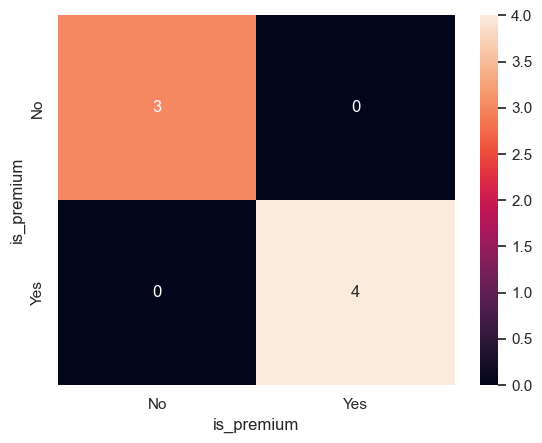

In [88]:
plot_bivariate_category_vs_category(df,categorical_columns)

In [ ]:
def plot_bivariate_numeric_vs_numeric(df,numerical_columns):
    #scatter-plot,kex-plot,line-plot
    for col in numerical_columns:
        for col2 in reversed(numerical_columns):
            if col!=col2:
                plt.Figure(figsize=(10,6))
                sns.scatterplot(df,x=col,y=col2)
                plt.xlabel(col)
                plt.ylabel(col2)
                plt.show()

                plt.Figure(figsize=(10,6))
                sns.lineplot(df,x=col,y=col2)
                plt.xlabel(col)
                plt.ylabel(col2)
                plt.show()

In [105]:
plot_bivariate_numeric_vs_numeric(df,numerical_columns)

In [116]:
def plot_bivariate_time_numeric(df,time_column,numerical_columns):
    for col in time_column:
        for col2 in numerical_columns:
            plt.Figure(figsize=(30,10))
            sns.lineplot(df,x=col,y=col2)
            plt.xlabel(col)
            plt.ylabel(col2)
            plt.xticks(rotation=45,ha='right')
            plt.show()

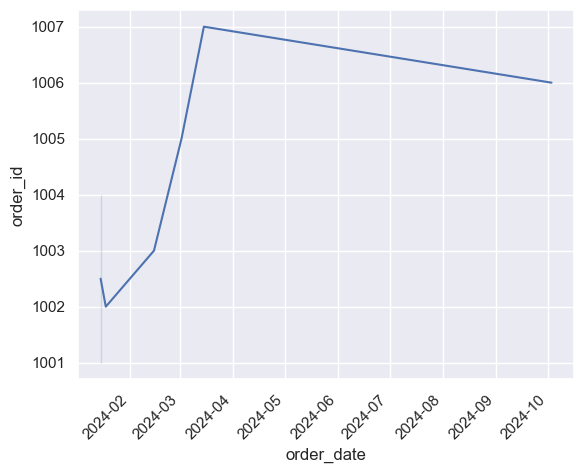

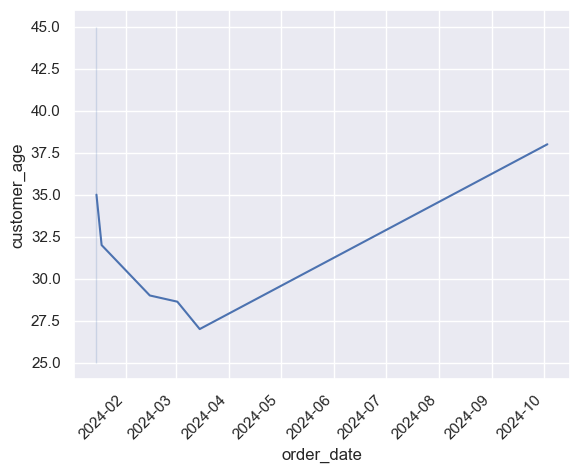

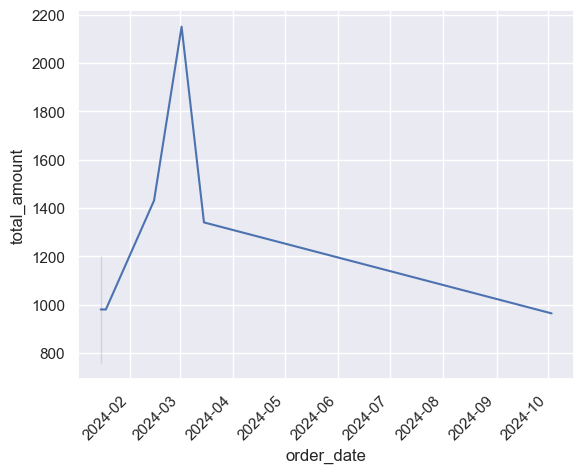

In [117]:
plot_bivariate_time_numeric(df,time_column,numerical_columns)

In [124]:
def plot_multivariate(df):
    plt.Figure(figsize=(10,6))
    sns.heatmap(df.corr(numeric_only=True),annot=True)
    plt.show()

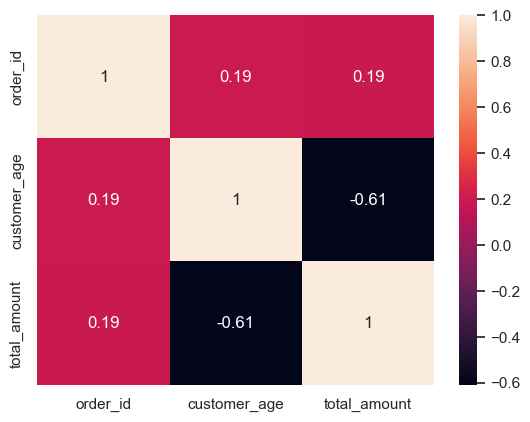

In [125]:
plot_multivariate(df)